# Extension 6.1 — Adaptive Re-Ranking (Hard-thresholding + Logistic Regression)
This notebook assumes you have **updated reranking CSVs** with columns:

- query_id
- inliers_rank0
- is_correct_rank0
- max_inliers
- is_correct_final

We will:
1) Sweep τ on **inliers_rank0** and compute:
   - Adaptive Final R@1 (true)
   - Fraction reranked
   - Average time and cost savings
2) Train Logistic Regression (LR) on TRAIN, select threshold on VAL, report on TEST:
   - LR predicts query hardness / benefit
3) Produce core plots and summary tables.

**Policy:** rerank if hard.
- Hard-thresholding: `inliers_rank0 < τ`
- LR gating: rerank if `p(hard) > τ_prob` (or p(benefit) > τ_prob)


In [1]:
!pip -q install numpy pandas scikit-learn tqdm matplotlib

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
PROJECT_ROOT = Path("/content/drive/MyDrive/VPR_Results")  # change if needed
LOGS_ROOT = PROJECT_ROOT / "logs_csv"

OUT_ROOT = PROJECT_ROOT / "results_6_1_adaptive_updated"
OUT_ROOT.mkdir(parents=True, exist_ok=True)

print("LOGS_ROOT:", LOGS_ROOT)
print("OUT_ROOT:", OUT_ROOT)


LOGS_ROOT: /content/drive/MyDrive/VPR_Results/logs_csv
OUT_ROOT: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated


## Time model (edit with your measured values)

Average query time under adaptive:
T_avg = T_global + frac_reranked * T_rerank

Savings vs always rerank:
saving = 1 - T_avg / (T_global + T_rerank)

## Discover runs

Expected layout:
logs/<VPR>/<split>/<dataset>/
  preds_superpoint-lg/   (torch files)
  preds_loftr/           (torch files)
  stats_preds_superpoint-lg.csv  (or similar)
  stats_preds_loftr.csv

In [6]:
def find_runs(logs_root: Path):
    runs = []
    for vpr_dir in sorted([p for p in logs_root.iterdir() if p.is_dir()]):
        for split_dir in sorted([p for p in vpr_dir.iterdir() if p.is_dir()]):
            for ds_dir in sorted([p for p in split_dir.iterdir() if p.is_dir()]):
                runs.append({"vpr": vpr_dir.name, "split": split_dir.name, "dataset": ds_dir.name, "run_dir": ds_dir})
    return runs

runs = find_runs(LOGS_ROOT)
print("Found runs:", len(runs))
runs[:5]

Found runs: 14


[{'vpr': 'MixVPR',
  'split': 'test',
  'dataset': 'sf_xs',
  'run_dir': PosixPath('/content/drive/MyDrive/VPR_Results/logs_csv/MixVPR/test/sf_xs')},
 {'vpr': 'MixVPR',
  'split': 'test',
  'dataset': 'svox_night',
  'run_dir': PosixPath('/content/drive/MyDrive/VPR_Results/logs_csv/MixVPR/test/svox_night')},
 {'vpr': 'MixVPR',
  'split': 'test',
  'dataset': 'svox_sun',
  'run_dir': PosixPath('/content/drive/MyDrive/VPR_Results/logs_csv/MixVPR/test/svox_sun')},
 {'vpr': 'MixVPR',
  'split': 'test',
  'dataset': 'tokyo_xs',
  'run_dir': PosixPath('/content/drive/MyDrive/VPR_Results/logs_csv/MixVPR/test/tokyo_xs')},
 {'vpr': 'MixVPR',
  'split': 'train',
  'dataset': 'svox_night',
  'run_dir': PosixPath('/content/drive/MyDrive/VPR_Results/logs_csv/MixVPR/train/svox_night')}]

## Find updated stats CSVs

We will search for files matching `stats_*.csv` inside each run folder.
Then infer matcher based on filename.

In [7]:
def infer_im_method(name: str):
    n = name.lower()
    if "loftr" in n:
        return "loftr"
    if "superpoint" in n or ("sp" in n and "lg" in n):
        return "superpoint-lg"
    return "unknown"

def find_stats_csvs(run_dir: Path):
    candidates = list(run_dir.rglob("stats_*.csv"))
    return candidates

rows = []
for r in runs:
    for p in find_stats_csvs(r["run_dir"]):
        im = infer_im_method(p.name)
        if im == "unknown":
            continue
        rows.append({
            "vpr": r["vpr"], "split": r["split"], "dataset": r["dataset"],
            "im": im, "csv_path": str(p)
        })

index_df = pd.DataFrame(rows).sort_values(["vpr","split","dataset","im"])
print("Found stats csv:", len(index_df))
index_df.head(20)

Found stats csv: 28


,vpr,split,dataset,im,csv_path
0,MixVPR,test,sf_xs,loftr,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
1,MixVPR,test,sf_xs,superpoint-lg,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
2,MixVPR,test,svox_night,loftr,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
3,MixVPR,test,svox_night,superpoint-lg,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
4,MixVPR,test,svox_sun,loftr,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
5,MixVPR,test,svox_sun,superpoint-lg,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
6,MixVPR,test,tokyo_xs,loftr,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
7,MixVPR,test,tokyo_xs,superpoint-lg,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
8,MixVPR,train,svox_night,loftr,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...
9,MixVPR,train,svox_night,superpoint-lg,/content/drive/MyDrive/VPR_Results/logs_csv/Mi...


## Load and validate updated CSV

We expect the new schema:
query_id, inliers_rank0, is_correct_rank0, max_inliers, is_correct_final

In [8]:
REQUIRED_COLS = ["query_id", "inliers_rank0", "is_correct_rank0", "max_inliers", "is_correct_final"]

def load_stats_csv(path: Path):
    df = pd.read_csv(path, sep=None, engine="python")
    df.columns = [c.strip() for c in df.columns]
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns {missing} in {path}")
    # types
    df["query_id"] = pd.to_numeric(df["query_id"], errors="coerce").astype(int)
    df["inliers_rank0"] = pd.to_numeric(df["inliers_rank0"], errors="coerce").fillna(0.0).astype(float)
    df["max_inliers"] = pd.to_numeric(df["max_inliers"], errors="coerce").fillna(0.0).astype(float)
    df["is_correct_rank0"] = pd.to_numeric(df["is_correct_rank0"], errors="coerce").fillna(0).astype(int)
    df["is_correct_final"] = pd.to_numeric(df["is_correct_final"], errors="coerce").fillna(0).astype(int)

    # derived: benefit of reranking
    df["benefit"] = ((df["is_correct_rank0"] == 0) & (df["is_correct_final"] == 1)).astype(int)
    df["harm"] = ((df["is_correct_rank0"] == 1) & (df["is_correct_final"] == 0)).astype(int)
    return df.sort_values("query_id").reset_index(drop=True)

# quick test
if len(index_df):
    test_path = Path(index_df.iloc[0]["csv_path"])
    dft = load_stats_csv(test_path)
    dft.head()


## Hard-thresholding sweep

Policy:
- rerank if `inliers_rank0 < τ`
Final adaptive correctness:
- if reranked -> is_correct_final
- else -> is_correct_rank0

In [9]:
def threshold_sweep(df: pd.DataFrame, taus: np.ndarray, im: str):
    inl0 = df["inliers_rank0"].to_numpy()
    y0 = df["is_correct_rank0"].to_numpy()
    yf = df["is_correct_final"].to_numpy()

    rows = []
    for tau in taus:
        rerank = (inl0 < tau)
        frac = rerank.mean()
        final = np.where(rerank, yf, y0)
        final_r1 = final.mean() * 100.0

        # how often rerank helps among reranked
        succ = yf[rerank].mean() * 100.0 if rerank.any() else np.nan
        ben = df.loc[rerank, "benefit"].mean() * 100.0 if rerank.any() else np.nan
        harm = df.loc[rerank, "harm"].mean() * 100.0 if rerank.any() else np.nan

        # timing
        t_avg = TIME_GLOBAL_DEFAULT + frac * TIME_RERANK[im]
        t_always = TIME_GLOBAL_DEFAULT + TIME_RERANK[im]
        saving = 1.0 - (t_avg / t_always)

        rows.append({
            "tau": float(tau),
            "frac_reranked": float(frac),
            "final_R@1_%": float(final_r1),
            "rerank_success_%": float(succ),
            "benefit_%": float(ben),
            "harm_%": float(harm),
            "time_avg_s": float(t_avg),
            "saving_vs_always": float(saving),
        })
    return pd.DataFrame(rows)

In [10]:
thr_dir = OUT_ROOT / "threshold_curves"
thr_dir.mkdir(parents=True, exist_ok=True)

all_thr = []
for _, row in tqdm(index_df.iterrows(), total=len(index_df), desc="Threshold sweep"):
    path = Path(row["csv_path"])
    df = load_stats_csv(path)

    # taus: percentiles of inliers_rank0
    taus = np.unique(np.percentile(df["inliers_rank0"], np.linspace(0, 100, 101))).astype(float)
    curve = threshold_sweep(df, taus, row["im"])

    out_path = thr_dir / f'{row["vpr"]}__{row["split"]}__{row["dataset"]}__{row["im"]}__thr.csv'
    curve.to_csv(out_path, index=False)
    all_thr.append(out_path)

print("Saved threshold curves:", len(all_thr))
all_thr[:3]

Threshold sweep: 100%|██████████| 28/28 [00:28<00:00,  1.01s/it]

Saved threshold curves: 28


[PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/threshold_curves/MixVPR__test__sf_xs__loftr__thr.csv'),
 PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/threshold_curves/MixVPR__test__sf_xs__superpoint-lg__thr.csv'),
 PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/threshold_curves/MixVPR__test__svox_night__loftr__thr.csv')]

## Plot threshold curves for one selected run

This plot is the core of the threshold-based analysis:
- Final R@1 vs fraction reranked
- Savings vs fraction reranked

Num curves: 28


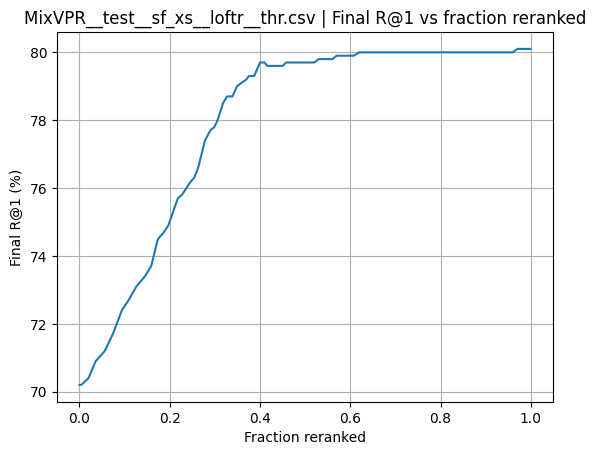

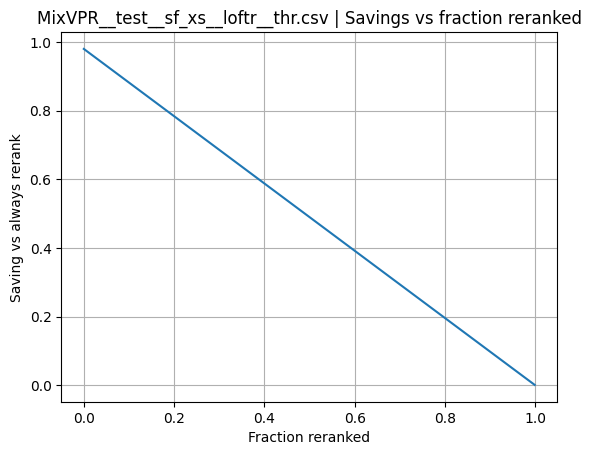

In [11]:
def plot_thr_curve(curve_path: Path, title=""):
    dfc = pd.read_csv(curve_path)

    plt.figure()
    plt.plot(dfc["frac_reranked"], dfc["final_R@1_%"])
    plt.xlabel("Fraction reranked")
    plt.ylabel("Final R@1 (%)")
    plt.title(title + " | Final R@1 vs fraction reranked")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(dfc["frac_reranked"], dfc["saving_vs_always"])
    plt.xlabel("Fraction reranked")
    plt.ylabel("Saving vs always rerank")
    plt.title(title + " | Savings vs fraction reranked")
    plt.grid(True)
    plt.show()

# select a curve file
curve_files = sorted(thr_dir.glob("*.csv"))
print("Num curves:", len(curve_files))
if curve_files:
    p = curve_files[0]
    plot_thr_curve(p, title=p.name)

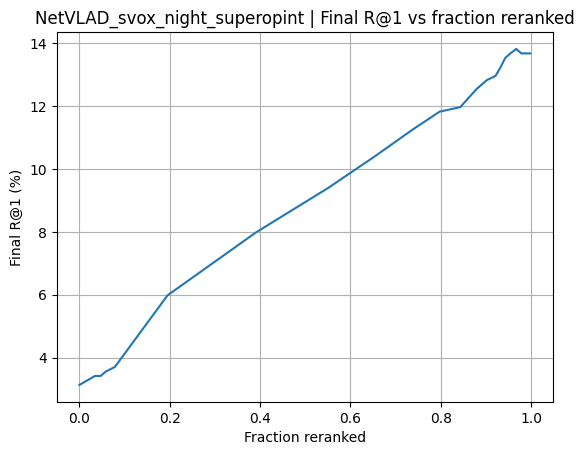

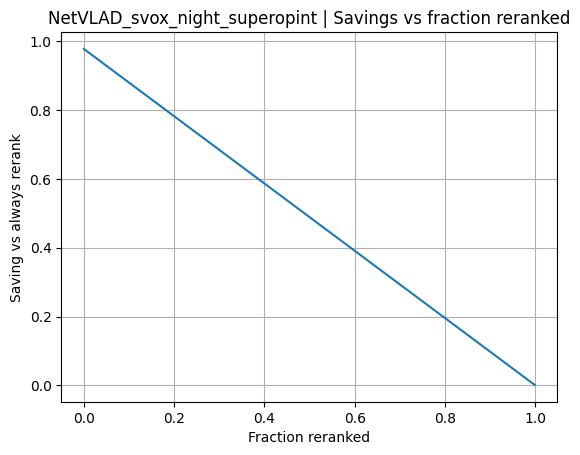

In [19]:
plot_thr_curve("/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/threshold_curves/NetVLAD__train__svox_night__superpoint-lg__thr.csv", "NetVLAD_svox_night_superopint")

## Logistic Regression

We implement two LR tasks:

### Task 1 (Hardness classifier)
Predict if query is **hard** (baseline retrieval fails):
- y_hard = 1 if is_correct_rank0 == 0 else 0

### Task 2 (Benefit classifier) [recommended]
Predict if reranking is **useful**:
- y_benefit = 1 if (rank0 wrong) and (final correct)

Features:
- inliers_rank0
- max_inliers
- gap = max_inliers - inliers_rank0
- log(1+features)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

def make_features(df: pd.DataFrame):
    x1 = df["inliers_rank0"].to_numpy(dtype=np.float32)
    x2 = df["max_inliers"].to_numpy(dtype=np.float32)
    gap = (x2 - x1).astype(np.float32)

    X = np.stack([x1, x2, gap], axis=1)
    Xlog = np.log1p(X)
    Xall = np.concatenate([X, Xlog], axis=1)
    feat_names = ["inliers_rank0", "max_inliers", "gap", "log_inliers_rank0", "log_max_inliers", "log_gap"]
    return Xall, feat_names

def fit_lr(X, y, C=1.0):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(C=C, class_weight="balanced", max_iter=2000))
    ])
    model.fit(X, y)
    return model

def lr_metrics(y, p):
    out = {
        "acc@0.5": float(accuracy_score(y, (p >= 0.5).astype(int))),
        "roc_auc": float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else np.nan,
        "auprc": float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else np.nan
    }
    return out

In [13]:
def collect_split(vpr, im, split):
    sub = index_df[(index_df["vpr"] == vpr) & (index_df["im"] == im) & (index_df["split"].str.lower() == split.lower())]
    dfs = []
    for _, r in sub.iterrows():
        if "gsv" in r["dataset"].lower():
            continue
        df = load_stats_csv(Path(r["csv_path"]))
        df["dataset"] = r["dataset"]
        dfs.append(df)
    if not dfs:
        return None
    return pd.concat(dfs, ignore_index=True)

available_vprs = sorted(index_df["vpr"].unique())
print("VPRs:", available_vprs)

VPRs: ['MixVPR', 'NetVLAD']


In [14]:
lr_dir = OUT_ROOT / "lr_models"
lr_dir.mkdir(parents=True, exist_ok=True)

models = {}  # (vpr,im,task) -> dict

Cs = [0.1, 0.3, 1.0, 3.0, 10.0]
rows = []

for vpr in available_vprs:
    for im in ["superpoint-lg", "loftr"]:
        train_df = collect_split(vpr, im, "train")
        val_df = collect_split(vpr, im, "val")
        if train_df is None or val_df is None:
            continue

        Xtr, feat_names = make_features(train_df)
        Xva, _ = make_features(val_df)

        # Task1: hard = not correct at rank0
        ytr_h = (train_df["is_correct_rank0"] == 0).astype(int).to_numpy()
        yva_h = (val_df["is_correct_rank0"] == 0).astype(int).to_numpy()

        # Task2: benefit
        ytr_b = train_df["benefit"].to_numpy()
        yva_b = val_df["benefit"].to_numpy()

        for task_name, ytr, yva in [("hard", ytr_h, yva_h), ("benefit", ytr_b, yva_b)]:
            best = None
            for C in Cs:
                m = fit_lr(Xtr, ytr, C=C)
                p = m.predict_proba(Xva)[:,1]
                met = lr_metrics(yva, p)
                score = met["auprc"]
                if best is None or score > best[0]:
                    best = (score, C, met, m)

            score, Cbest, metbest, m_best = best
            models[(vpr, im, task_name)] = {"model": m_best, "C": Cbest, "feat_names": feat_names, "val_metrics": metbest}

            rows.append({
                "vpr": vpr, "im": im, "task": task_name,
                "C_best": Cbest,
                "val_auprc": metbest["auprc"],
                "val_roc_auc": metbest["roc_auc"],
                "val_acc@0.5": metbest["acc@0.5"],
            })

pd.DataFrame(rows).sort_values(["vpr","im","task"])

,vpr,im,task,C_best,val_auprc,val_roc_auc,val_acc@0.5
3,MixVPR,loftr,benefit,0.1,0.761468,0.974416,0.942
2,MixVPR,loftr,hard,0.3,0.661566,0.941714,0.892
1,MixVPR,superpoint-lg,benefit,0.1,0.876636,0.982431,0.948
0,MixVPR,superpoint-lg,hard,1.0,0.588385,0.936171,0.893
7,NetVLAD,loftr,benefit,0.1,0.920467,0.967032,0.895
6,NetVLAD,loftr,hard,10.0,0.961529,0.972254,0.865
5,NetVLAD,superpoint-lg,benefit,0.3,0.942782,0.973969,0.922
4,NetVLAD,superpoint-lg,hard,0.1,0.948911,0.970058,0.920


## LR gating curves on TEST

Policy:
- rerank if p(task=hard) > τ_prob  (or p(benefit)>τ_prob)

Final correctness:
- if reranked -> is_correct_final
- else -> is_correct_rank0

We will output curves and summary budgets.

In [15]:
def lr_gating_curve(df: pd.DataFrame, p: np.ndarray, im: str, taus=np.linspace(0,1,101)):
    y0 = df["is_correct_rank0"].to_numpy()
    yf = df["is_correct_final"].to_numpy()

    rows = []
    for tau in taus:
        rerank = (p > tau)
        frac = rerank.mean()
        final = np.where(rerank, yf, y0)
        final_r1 = final.mean() * 100.0

        t_avg = TIME_GLOBAL_DEFAULT + frac * TIME_RERANK[im]
        t_always = TIME_GLOBAL_DEFAULT + TIME_RERANK[im]
        saving = 1.0 - (t_avg / t_always)

        rows.append({
            "tau_prob": float(tau),
            "frac_reranked": float(frac),
            "final_R@1_%": float(final_r1),
            "time_avg_s": float(t_avg),
            "saving_vs_always": float(saving),
        })
    return pd.DataFrame(rows)

In [16]:
lr_curve_dir = OUT_ROOT / "lr_curves"
lr_curve_dir.mkdir(parents=True, exist_ok=True)

saved = []
for _, r in tqdm(index_df.iterrows(), total=len(index_df), desc="LR curves"):
    vpr, split, ds, im = r["vpr"], r["split"], r["dataset"], r["im"]
    if split.lower() != "test":
        continue

    df = load_stats_csv(Path(r["csv_path"]))
    X, _ = make_features(df)

    for task in ["hard", "benefit"]:
        key = (vpr, im, task)
        if key not in models:
            continue
        m = models[key]["model"]
        p = m.predict_proba(X)[:,1]

        curve = lr_gating_curve(df, p, im, taus=np.linspace(0,1,101))
        out_path = lr_curve_dir / f"{vpr}__test__{ds}__{im}__{task}__lr.csv"
        curve.to_csv(out_path, index=False)
        saved.append(out_path)

print("Saved LR test curves:", len(saved))
saved[:3]

LR curves: 100%|██████████| 28/28 [00:08<00:00,  3.15it/s]

Saved LR test curves: 32


[PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/lr_curves/MixVPR__test__sf_xs__loftr__hard__lr.csv'),
 PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/lr_curves/MixVPR__test__sf_xs__loftr__benefit__lr.csv'),
 PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/lr_curves/MixVPR__test__sf_xs__superpoint-lg__hard__lr.csv')]

Num LR files: 32


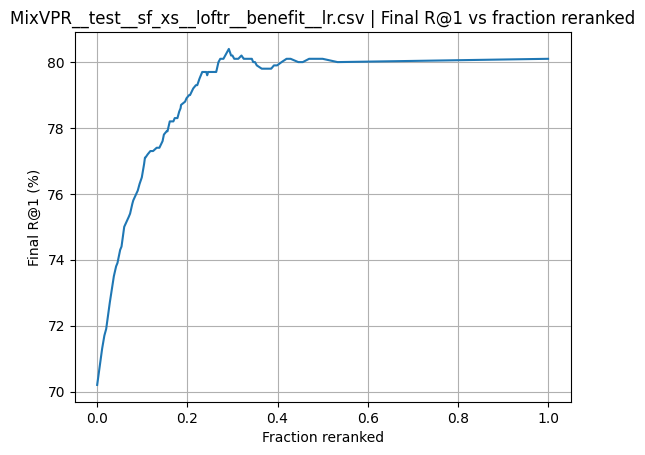

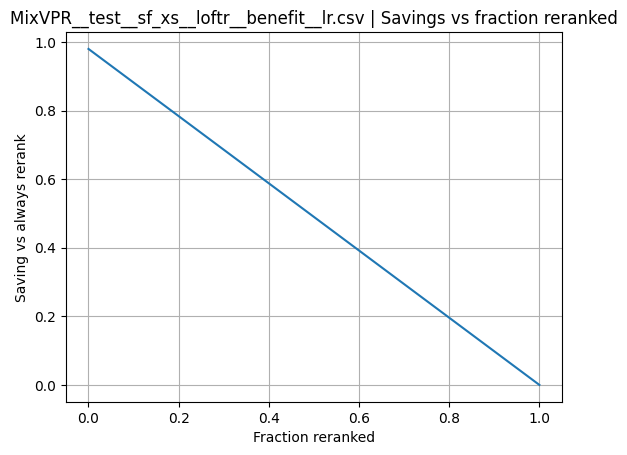

In [17]:
def plot_lr_curve(curve_path: Path, title=""):
    dfc = pd.read_csv(curve_path)

    plt.figure()
    plt.plot(dfc["frac_reranked"], dfc["final_R@1_%"])
    plt.xlabel("Fraction reranked")
    plt.ylabel("Final R@1 (%)")
    plt.title(title + " | Final R@1 vs fraction reranked")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(dfc["frac_reranked"], dfc["saving_vs_always"])
    plt.xlabel("Fraction reranked")
    plt.ylabel("Saving vs always rerank")
    plt.title(title + " | Savings vs fraction reranked")
    plt.grid(True)
    plt.show()

lr_files = sorted(lr_curve_dir.glob("*.csv"))
print("Num LR files:", len(lr_files))
if lr_files:
    plot_lr_curve(lr_files[0], title=lr_files[0].name)

In [18]:
def best_under_budget(curve: pd.DataFrame, budget: float):
    sub = curve[curve["frac_reranked"] <= budget]
    if len(sub) == 0:
        return None
    return sub.sort_values("final_R@1_%", ascending=False).iloc[0]

def summarize_dir(curve_dir: Path, kind: str):
    rows = []
    for p in sorted(curve_dir.glob("*.csv")):
        dfc = pd.read_csv(p)
        name = p.stem

        # parse name loosely
        parts = name.split("__")
        # threshold curves: vpr__split__dataset__im__thr
        # lr curves: vpr__test__dataset__im__task__lr
        if kind == "threshold":
            vpr, split, ds, im = parts[0], parts[1], parts[2], parts[3]
            method = "thr"
            task = "-"
        else:
            vpr, split, ds, im, task = parts[0], parts[1], parts[2], parts[3], parts[4]
            method = "lr"

        for budget in [0.1,0.2,0.3,0.5]:
            best = best_under_budget(dfc, budget)
            if best is None:
                continue
            rows.append({
                "kind": kind, "method": method, "task": task,
                "vpr": vpr, "split": split, "dataset": ds, "im": im,
                "budget": budget,
                "frac_reranked": float(best["frac_reranked"]),
                "final_R@1_%": float(best["final_R@1_%"]),
                "saving_vs_always": float(best["saving_vs_always"]),
                "time_avg_s": float(best["time_avg_s"]),
                "param": float(best.get("tau", best.get("tau_prob", np.nan)))
            })
    return pd.DataFrame(rows)

thr_summary = summarize_dir(thr_dir, "threshold")
lr_summary  = summarize_dir(lr_curve_dir, "lr")

summary = pd.concat([thr_summary, lr_summary], ignore_index=True).sort_values(
    ["dataset","vpr","im","kind","task","budget"]
)

out_path = OUT_ROOT / "summary_budgets.csv"
summary.to_csv(out_path, index=False)
print("Saved:", out_path)
summary.head(50)

Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/summary_budgets.csv


,kind,method,task,vpr,split,dataset,im,budget,frac_reranked,final_R@1_%,saving_vs_always,time_avg_s,param
112,lr,lr,benefit,MixVPR,test,sf_xs,loftr,0.1,0.099,76.5,0.882659,0.46115,0.79
113,lr,lr,benefit,MixVPR,test,sf_xs,loftr,0.2,0.198,78.9,0.785674,0.84230,0.54
114,lr,lr,benefit,MixVPR,test,sf_xs,loftr,0.3,0.292,80.4,0.693588,1.20420,0.32
115,lr,lr,benefit,MixVPR,test,sf_xs,loftr,0.5,0.292,80.4,0.693588,1.20420,0.32
116,lr,lr,hard,MixVPR,test,sf_xs,loftr,0.1,0.098,73.1,0.883639,0.45730,0.86
117,lr,lr,hard,MixVPR,test,sf_xs,loftr,0.2,0.194,76.4,0.789593,0.82690,0.63
118,lr,lr,hard,MixVPR,test,sf_xs,loftr,0.3,0.297,78.8,0.688690,1.22345,0.22
119,lr,lr,hard,MixVPR,test,sf_xs,loftr,0.5,0.411,79.9,0.577010,1.66235,0.02
0,threshold,thr,-,MixVPR,test,sf_xs,loftr,0.1,0.094,72.4,0.887557,0.44190,13.00
48,threshold,thr,-,MixVPR,val,sf_xs,loftr,0.1,0.099,85.3,0.882659,0.46115,16.00


## Plot: Compare baseline vs always rerank vs best adaptive

For each (dataset, vpr, im) on TEST:
- baseline = mean(is_correct_rank0)
- always_rerank = mean(is_correct_final)
- adaptive = best final_R@1 under budgets (10/20/50%)

In [19]:
# Build baseline/always table from test CSVs
test_rows = []
for _, r in index_df.iterrows():
    if r["split"].lower() != "test":
        continue
    df = load_stats_csv(Path(r["csv_path"]))
    test_rows.append({
        "vpr": r["vpr"], "dataset": r["dataset"], "im": r["im"],
        "baseline_R@1_%": df["is_correct_rank0"].mean()*100,
        "always_rerank_R@1_%": df["is_correct_final"].mean()*100,
    })
base_tbl = pd.DataFrame(test_rows)

# take best adaptive from summaries
best_adaptive = summary[(summary["split"].str.lower()=="test") & (summary["budget"].isin([0.1,0.2,0.5]))]
best_adaptive = best_adaptive.groupby(["vpr","dataset","im","budget","kind","task"], as_index=False).first()

base_tbl.head(), best_adaptive.head()

(      vpr     dataset             im  baseline_R@1_%  always_rerank_R@1_%
 0  MixVPR       sf_xs          loftr       70.200000            80.100000
 1  MixVPR       sf_xs  superpoint-lg       70.200000            81.000000
 2  MixVPR  svox_night          loftr       62.697448            82.503038
 3  MixVPR  svox_night  superpoint-lg       62.697448            81.895504
 4  MixVPR    svox_sun          loftr       85.362998            93.442623,
       vpr dataset     im  budget       kind     task method split  \
 0  MixVPR   sf_xs  loftr     0.1         lr  benefit     lr  test   
 1  MixVPR   sf_xs  loftr     0.1         lr     hard     lr  test   
 2  MixVPR   sf_xs  loftr     0.1  threshold        -    thr  test   
 3  MixVPR   sf_xs  loftr     0.2         lr  benefit     lr  test   
 4  MixVPR   sf_xs  loftr     0.2         lr     hard     lr  test   
 
    frac_reranked  final_R@1_%  saving_vs_always  time_avg_s  param  
 0          0.099         76.5          0.882659     0.46

In [20]:
print("Baseline vs Always-rerank (TEST):")
display(base_tbl)

print("Best adaptive under budgets (TEST):")
display(best_adaptive.sort_values(["dataset","vpr","im","kind","task","budget"]))

Baseline vs Always-rerank (TEST):


,vpr,dataset,im,baseline_R@1_%,always_rerank_R@1_%
0,MixVPR,sf_xs,loftr,70.200000,80.100000
1,MixVPR,sf_xs,superpoint-lg,70.200000,81.000000
2,MixVPR,svox_night,loftr,62.697448,82.503038
3,MixVPR,svox_night,superpoint-lg,62.697448,81.895504
4,MixVPR,svox_sun,loftr,85.362998,93.442623
5,MixVPR,svox_sun,superpoint-lg,85.362998,91.334895
6,MixVPR,tokyo_xs,loftr,78.095238,89.841270
7,MixVPR,tokyo_xs,superpoint-lg,78.095238,88.888889
8,NetVLAD,sf_xs,loftr,27.200000,53.600000
9,NetVLAD,sf_xs,superpoint-lg,27.200000,53.200000


Best adaptive under budgets (TEST):


,vpr,dataset,im,budget,kind,task,method,split,frac_reranked,final_R@1_%,saving_vs_always,time_avg_s,param
0,MixVPR,sf_xs,loftr,0.1,lr,benefit,lr,test,0.099000,76.500000,0.882659,0.461150,0.79
3,MixVPR,sf_xs,loftr,0.2,lr,benefit,lr,test,0.198000,78.900000,0.785674,0.842300,0.54
6,MixVPR,sf_xs,loftr,0.5,lr,benefit,lr,test,0.292000,80.400000,0.693588,1.204200,0.32
1,MixVPR,sf_xs,loftr,0.1,lr,hard,lr,test,0.098000,73.100000,0.883639,0.457300,0.86
4,MixVPR,sf_xs,loftr,0.2,lr,hard,lr,test,0.194000,76.400000,0.789593,0.826900,0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,NetVLAD,tokyo_xs,superpoint-lg,0.2,lr,hard,lr,test,0.155556,50.476190,0.825679,0.627556,0.98
142,NetVLAD,tokyo_xs,superpoint-lg,0.5,lr,hard,lr,test,0.495238,64.126984,0.493545,1.823238,0.81
137,NetVLAD,tokyo_xs,superpoint-lg,0.1,threshold,-,thr,test,0.053968,50.793651,0.925009,0.269968,4.00
140,NetVLAD,tokyo_xs,superpoint-lg,0.2,threshold,-,thr,test,0.111111,52.380952,0.869136,0.471111,5.00


# Report Data

In [26]:
from pathlib import Path
import pandas as pd
import shutil

OUT_ROOT = globals().get("OUT_ROOT", Path("/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated"))

REPORT_DIR = OUT_ROOT / "report_assets"
TABLE_SEL = REPORT_DIR / "tables_selected"
FIG_SEL   = REPORT_DIR / "figures_selected"

TABLE_SEL.mkdir(parents=True, exist_ok=True)
FIG_SEL.mkdir(parents=True, exist_ok=True)

print("Using OUT_ROOT:", OUT_ROOT)

Using OUT_ROOT: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated


In [27]:
from pathlib import Path
import pandas as pd
import numpy as np

# Prende i path dal notebook se esistono già
PROJECT_ROOT = globals().get("PROJECT_ROOT", Path("/content/drive/MyDrive/VPR_Results"))
LOGS_ROOT    = globals().get("LOGS_ROOT", PROJECT_ROOT / "logs_csv")
OUT_ROOT     = globals().get("OUT_ROOT", PROJECT_ROOT / "results_6_1_adaptive_updated")

REPORT_DIR = OUT_ROOT / "report_assets"
TABLE_SEL  = REPORT_DIR / "tables_selected"
TABLE_SEL.mkdir(parents=True, exist_ok=True)

summary_path = OUT_ROOT / "summary_budgets.csv"
summary = pd.read_csv(summary_path)

# ---------- helper: ricostruisco l'indice degli stats_*.csv (come nel notebook) ----------
def infer_im_method(name: str):
    n = name.lower()
    if "loftr" in n:
        return "loftr"
    if "superpoint" in n or ("sp" in n and "lg" in n):
        return "superpoint-lg"
    return "unknown"

def find_runs(logs_root: Path):
    runs = []
    for vpr_dir in sorted([p for p in logs_root.iterdir() if p.is_dir()]):
        for split_dir in sorted([p for p in vpr_dir.iterdir() if p.is_dir()]):
            for ds_dir in sorted([p for p in split_dir.iterdir() if p.is_dir()]):
                runs.append({"vpr": vpr_dir.name, "split": split_dir.name, "dataset": ds_dir.name, "run_dir": ds_dir})
    return runs

def find_stats_csvs(run_dir: Path):
    return list(run_dir.rglob("stats_*.csv"))

runs = find_runs(LOGS_ROOT)
rows = []
for r in runs:
    for p in find_stats_csvs(r["run_dir"]):
        im = infer_im_method(p.name)
        if im == "unknown":
            continue
        rows.append({
            "vpr": r["vpr"], "split": r["split"], "dataset": r["dataset"],
            "im": im, "csv_path": str(p)
        })
index_df = pd.DataFrame(rows).sort_values(["vpr","split","dataset","im"])
print("Found stats csv:", len(index_df))

# ---------- baseline/always dal CSV stats (solo test) ----------
def load_stats_csv(p: Path) -> pd.DataFrame:
    return pd.read_csv(p)

test_idx = index_df[index_df["split"].str.lower() == "test"].copy()
base_rows = []
for r in test_idx.itertuples(index=False):
    df = load_stats_csv(Path(r.csv_path))
    base_rows.append({
        "vpr": r.vpr, "dataset": r.dataset, "im": r.im,
        "R@1_baseline": df["is_correct_rank0"].mean() * 100.0,
        "R@1_always":   df["is_correct_final"].mean() * 100.0,
    })
base_tbl = pd.DataFrame(base_rows)

# ---------- best adaptive @ budget 20% da summary_budgets ----------
B = 0.20
summary_test = summary[summary["split"].str.lower() == "test"].copy()
cand = summary_test[summary_test["budget"] == B].copy()

# per combo scelgo il migliore (tra threshold e LR-hard/LR-benefit) in termini di R@1
best = (
    cand.sort_values("final_R@1_%", ascending=False)
        .groupby(["vpr","dataset","im"], as_index=False)
        .head(1)
        .copy()
)

# saving: nel tuo summary è "saving_vs_always" (0-1)
best["saving_%"] = best["saving_vs_always"] * 100.0

# etichetta metodo leggibile
best["adaptive_method"] = np.where(best["kind"].str.lower() == "threshold",
                                   "THR",
                                   "LR-" + best["task"].astype(str))

main = (base_tbl
        .merge(best[["vpr","dataset","im","adaptive_method","param","final_R@1_%","frac_reranked","time_avg_s","saving_%"]],
               on=["vpr","dataset","im"], how="left")
        .rename(columns={"final_R@1_%":"R@1_adaptive"})
        .sort_values(["vpr","dataset","im"])
)

display(main)

csv_path = TABLE_SEL / "main_results_budget20.csv"
tex_path = TABLE_SEL / "main_results_budget20.tex"
main.to_csv(csv_path, index=False)
main.to_latex(tex_path, index=False, float_format="%.2f")

print("Saved:", csv_path)
print("Saved:", tex_path)

Found stats csv: 28


,vpr,dataset,im,R@1_baseline,R@1_always,adaptive_method,param,R@1_adaptive,frac_reranked,time_avg_s,saving_%
0,MixVPR,sf_xs,loftr,70.200000,80.100000,LR-benefit,0.54,78.900000,0.198000,0.842300,78.567430
1,MixVPR,sf_xs,superpoint-lg,70.200000,81.000000,LR-benefit,0.60,79.700000,0.188000,0.741760,79.395556
2,MixVPR,svox_night,loftr,62.697448,82.503038,LR-benefit,0.78,79.951397,0.194411,0.828481,78.919054
3,MixVPR,svox_night,superpoint-lg,62.697448,81.895504,LR-benefit,0.78,80.072904,0.198056,0.777157,78.412313
4,MixVPR,svox_sun,loftr,85.362998,93.442623,LR-benefit,0.39,92.974239,0.182670,0.783279,80.069245
5,MixVPR,svox_sun,superpoint-lg,85.362998,91.334895,LR-benefit,0.43,92.154567,0.166276,0.665293,81.519646
6,MixVPR,tokyo_xs,loftr,78.095238,89.841270,LR-benefit,0.50,88.888889,0.200000,0.850000,78.371501
7,MixVPR,tokyo_xs,superpoint-lg,78.095238,88.888889,LR-benefit,0.52,87.936508,0.193651,0.761651,78.843034
8,NetVLAD,sf_xs,loftr,27.200000,53.600000,LR-benefit,0.94,45.800000,0.192000,0.819200,79.155216
9,NetVLAD,sf_xs,superpoint-lg,27.200000,53.200000,LR-benefit,0.97,45.100000,0.190000,0.748800,79.200000


Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/tables_selected/main_results_budget20.csv
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/tables_selected/main_results_budget20.tex


In [28]:
import pandas as pd

macro = (
    main.groupby("vpr", as_index=False)
        .agg({
            "R@1_baseline":"mean",
            "R@1_always":"mean",
            "R@1_adaptive":"mean",
            "saving_%":"mean"
        })
)

display(macro)

csv_path = TABLE_SEL / "macro_average_budget20.csv"
tex_path = TABLE_SEL / "macro_average_budget20.tex"
macro.to_csv(csv_path, index=False)
macro.to_latex(tex_path, index=False, float_format="%.2f")

print("Saved:", csv_path)
print("Saved:", tex_path)

,vpr,R@1_baseline,R@1_always,R@1_adaptive,saving_%
0,MixVPR,74.088921,86.125777,85.072313,79.262222
1,NetVLAD,30.105927,52.190168,46.996420,78.801380


Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/tables_selected/macro_average_budget20.csv
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/tables_selected/macro_average_budget20.tex


In [29]:
lr20 = summary_test[(summary_test["kind"].str.lower()=="lr") & (summary_test["budget"]==0.20)].copy()
lr20["saving_%"] = lr20["saving_vs_always"] * 100.0

lr_cmp = (
    lr20.groupby(["vpr","im","task"], as_index=False)
        .agg({
            "final_R@1_%":"mean",
            "frac_reranked":"mean",
            "time_avg_s":"mean",
            "saving_%":"mean"
        })
        .rename(columns={"final_R@1_%":"R@1_%_avg"})
        .sort_values(["vpr","im","task"])
)

display(lr_cmp)

csv_path = TABLE_SEL / "lr_hard_vs_benefit_budget20_avg.csv"
tex_path = TABLE_SEL / "lr_hard_vs_benefit_budget20_avg.tex"
lr_cmp.to_csv(csv_path, index=False)
lr_cmp.to_latex(tex_path, index=False, float_format="%.2f")

print("Saved:", csv_path)
print("Saved:", tex_path)

,vpr,im,task,R@1_%_avg,frac_reranked,time_avg_s,saving_%
0,MixVPR,loftr,benefit,85.178631,0.193770,0.826015,78.981808
1,MixVPR,loftr,hard,81.601627,0.195968,0.834478,78.766473
2,MixVPR,superpoint-lg,benefit,84.965995,0.186496,0.736465,79.542637
3,MixVPR,superpoint-lg,hard,80.612657,0.195477,0.768080,78.664431
4,NetVLAD,loftr,benefit,47.131254,0.194656,0.829426,78.895008
5,NetVLAD,loftr,hard,31.132671,0.128623,0.575200,85.363865
6,NetVLAD,superpoint-lg,benefit,46.861585,0.195034,0.766521,78.707751
7,NetVLAD,superpoint-lg,hard,30.730329,0.133419,0.549636,84.732340


Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/tables_selected/lr_hard_vs_benefit_budget20_avg.csv
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/tables_selected/lr_hard_vs_benefit_budget20_avg.tex


In [30]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil

PROJECT_ROOT = globals().get("PROJECT_ROOT", Path("/content/drive/MyDrive/VPR_Results"))
LOGS_ROOT    = globals().get("LOGS_ROOT", PROJECT_ROOT / "logs_csv")
OUT_ROOT     = globals().get("OUT_ROOT", PROJECT_ROOT / "results_6_1_adaptive_updated")

THR_DIR = OUT_ROOT / "threshold_curves"
LR_DIR  = OUT_ROOT / "lr_curves"

FIG_DIR = OUT_ROOT / "report_assets" / "figures"
FIG_SEL = OUT_ROOT / "report_assets" / "figures_selected"
FIG_DIR.mkdir(parents=True, exist_ok=True)
FIG_SEL.mkdir(parents=True, exist_ok=True)

def _im_tokens(im: str):
    im = im.lower()
    if im == "loftr":
        return ["loftr"]
    if im in ["superpoint-lg", "superpoint_lg", "splg"]:
        return ["superpoint", "lightglue", "sp", "lg", "superpoint-lg"]
    return [im]

def find_stats_csv(vpr: str, split: str, dataset: str, im: str) -> Path:
    run_dir = LOGS_ROOT / vpr / split / dataset
    cand = list(run_dir.rglob("stats_*.csv"))
    if not cand:
        raise FileNotFoundError(f"No stats_*.csv under {run_dir}")
    toks = _im_tokens(im)
    scored = []
    for p in cand:
        name = p.name.lower()
        score = sum(t in name for t in toks)
        scored.append((score, len(str(p)), p))
    scored.sort(reverse=True)  # max score first, then shorter path
    best = scored[0][2]
    if scored[0][0] == 0:
        print(f"[WARN] No clear IM match for {im} in {run_dir}. Using: {best.name}")
    return best

def load_curve(path: Path) -> pd.DataFrame:
    dfc = pd.read_csv(path)
    needed = {"frac_reranked","final_R@1_%","saving_vs_always"}
    miss = needed - set(dfc.columns)
    if miss:
        raise KeyError(f"Missing columns {miss} in {path.name}. Columns: {list(dfc.columns)}")
    return dfc

def best_under_budget(curve: pd.DataFrame, budget: float):
    c = curve[curve["frac_reranked"] <= budget]
    if len(c) == 0:
        return curve.iloc[0]
    return c.loc[c["final_R@1_%"].idxmax()]

print("OUT_ROOT:", OUT_ROOT)
print("FIG_DIR:", FIG_DIR)

OUT_ROOT: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated
FIG_DIR: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures


In [31]:
def save_tradeoff_plot(vpr: str, dataset: str, im: str, budget: float = 0.20, split: str = "test"):
    # curve paths
    thr_path = THR_DIR / f"{vpr}__{split}__{dataset}__{im}__thr.csv"
    lr_h_path = LR_DIR / f"{vpr}__test__{dataset}__{im}__hard__lr.csv"
    lr_b_path = LR_DIR / f"{vpr}__test__{dataset}__{im}__benefit__lr.csv"

    if not thr_path.exists():
        print("[MISS]", thr_path)
        return None

    thr = load_curve(thr_path)

    lr_h = load_curve(lr_h_path) if lr_h_path.exists() else None
    lr_b = load_curve(lr_b_path) if lr_b_path.exists() else None

    # baseline/always from stats (robusto e coerente)
    stats_path = find_stats_csv(vpr, split, dataset, im)
    st = pd.read_csv(stats_path)
    r1_base = st["is_correct_rank0"].mean() * 100.0
    r1_alw  = st["is_correct_final"].mean() * 100.0

    # budget points
    thr_p = best_under_budget(thr, budget)
    lrh_p = best_under_budget(lr_h, budget) if lr_h is not None else None
    lrb_p = best_under_budget(lr_b, budget) if lr_b is not None else None

    # plot
    plt.figure(figsize=(7.2, 4.6))
    plt.plot(thr["frac_reranked"], thr["final_R@1_%"], label="THR")

    if lr_h is not None:
        plt.plot(lr_h["frac_reranked"], lr_h["final_R@1_%"], label="LR-hard")
    if lr_b is not None:
        plt.plot(lr_b["frac_reranked"], lr_b["final_R@1_%"], label="LR-benefit")

    # baseline / always points
    plt.scatter([0.0], [r1_base], marker="o", label=f"Baseline ({r1_base:.1f})")
    plt.scatter([1.0], [r1_alw], marker="o", label=f"Always ({r1_alw:.1f})")

    # budget markers
    plt.axvline(budget, linestyle="--", linewidth=1)
    plt.scatter([thr_p["frac_reranked"]], [thr_p["final_R@1_%"]], marker="x")
    if lrh_p is not None:
        plt.scatter([lrh_p["frac_reranked"]], [lrh_p["final_R@1_%"]], marker="x")
    if lrb_p is not None:
        plt.scatter([lrb_p["frac_reranked"]], [lrb_p["final_R@1_%"]], marker="x")

    plt.xlabel("Fraction reranked")
    plt.ylabel("Final Recall@1 (%)")
    plt.title(f"Trade-off | {vpr} | {dataset} | {im} | budget={int(budget*100)}%")
    plt.grid(True)
    plt.legend()

    out_name = f"tradeoff_{vpr}_{dataset}_{im}.png"
    out_path = FIG_DIR / out_name
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

    # copy to selected
    dst = FIG_SEL / out_name
    shutil.copy(out_path, dst)

    print("Saved:", out_path)
    return out_path

# --- scegli QUI i 2–4 grafici che vuoi nel report ---
SELECTED = [
    ("MixVPR",  "sf_xs",      "superpoint-lg"),
    ("MixVPR",  "svox_night", "superpoint-lg"),
    ("NetVLAD", "sf_xs",      "loftr"),
    ("NetVLAD", "svox_night", "loftr"),
]

saved = []
for vpr, ds, im in SELECTED:
    p = save_tradeoff_plot(vpr, ds, im, budget=0.20, split="test")
    if p is not None:
        saved.append(p)

print("\nSaved tradeoff plots:", len(saved))
print("Figures in:", FIG_DIR)
print("Selected in:", FIG_SEL)

Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tradeoff_MixVPR_sf_xs_superpoint-lg.png
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tradeoff_MixVPR_svox_night_superpoint-lg.png
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tradeoff_NetVLAD_sf_xs_loftr.png
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tradeoff_NetVLAD_svox_night_loftr.png

Saved tradeoff plots: 4
Figures in: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures
Selected in: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures_selected


In [37]:
def save_tau_train_plot(vpr: str, im: str, tau_mark: float = 10.0, x_max: int = 50):
    p_sun   = THR_DIR / f"{vpr}__train__svox_sun__{im}__thr.csv"
    p_night = THR_DIR / f"{vpr}__train__svox_night__{im}__thr.csv"
    if not p_sun.exists() or not p_night.exists():
        print("[MISS]", p_sun, "or", p_night)
        return None

    sun = pd.read_csv(p_sun)
    night = pd.read_csv(p_night)

    if "tau" not in sun.columns or "tau" not in night.columns:
        raise KeyError(f"'tau' missing. Sun cols={list(sun.columns)} Night cols={list(night.columns)}")

    plt.figure(figsize=(7.2, 4.6))
    plt.plot(sun["tau"], sun["final_R@1_%"], label="SVOX Sun (train)")
    plt.plot(night["tau"], night["final_R@1_%"], label="SVOX Night (train)")
    plt.axvline(tau_mark, linestyle="--", linewidth=1, label=f"tau={tau_mark:g}")

    plt.xlabel("Inlier threshold τ")
    plt.ylabel("Final Recall@1 (%)")
    plt.title(f"τ selection on train | {vpr} | {im}")
    plt.grid(True)
    plt.legend()

    # --- force x-axis to show up to 100 (and start at 0 for readability) ---
    plt.xlim(0, x_max)

    out_name = f"tau_train_{vpr}_{im}.png"
    out_path = FIG_DIR / out_name
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close()

    shutil.copy(out_path, FIG_SEL / out_name)
    print("Saved:", out_path)
    return out_path

# esempi
save_tau_train_plot("NetVLAD", "loftr", tau_mark=10.0, x_max=50)
save_tau_train_plot("MixVPR", "superpoint-lg", tau_mark=10.0, x_max=50)

Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tau_train_NetVLAD_loftr.png
Saved: /content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tau_train_MixVPR_superpoint-lg.png


PosixPath('/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated/report_assets/figures/tau_train_MixVPR_superpoint-lg.png')

In [38]:
shutil.make_archive('/content/drive/MyDrive/VPR_Results/extension', 'zip', '/content/drive/MyDrive/VPR_Results/results_6_1_adaptive_updated')

'/content/drive/MyDrive/VPR_Results/extension.zip'